The Classification for several selected band sets from four algorithms are calculated here. 

In [1]:
import pandas as pd
import time
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
indianPath = Path(r'C:\Datasets\IndianPines\Indian_pines_corrected.mat')
indianPathGt = Path(r'C:\Datasets\IndianPines\Indian_pines_gt.mat')

def read_indianPines():
    Indian_X = loadmat(indianPath)['indian_pines_corrected']
    Indian_Y = loadmat(indianPathGt)['indian_pines_gt']
    return Indian_X, Indian_Y


In [3]:
def bands_separation(bands, datasetX, datasetY):
    
    #Read data
    data_X = datasetX
    data_Y = datasetY
    
    data_X_selected = data_X[:,:,bands]

    print(data_X_selected.shape)

    #data dimensions
    x, y, z = data_X_selected.shape

    #reshapes arrays to have all data of each matrix into vectors
    data_X2d = data_X_selected.reshape((x * y, z))
    data_Y2d = data_Y.reshape((x * y, 1))

In [4]:
def extract_pixels(X, y):
    q = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(data = q)
    df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
    df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
    #df.to_csv('Dataset.csv')
    return df

In [5]:
#Reading data from HBS algorithms
def HBS_bands():
    bands_FDPC = loadmat('SelectedBandsOCF.mat')['band_FDPC']

    #bands_NC_IE = loadmat('SelectedBandsOCF.mat')['band_NC_IE']

    bands_simil = loadmat('SelectedSBS.mat')['bands_simil']

    bands_svd = loadmat('SelectedSBS.mat')['bands_svd']

    #bands_EGCSR = np.load("bands_EGCSR.npy").astype(int) + 1
    
    bands_bombs = np.load("bands_bombs.npy").astype(int)

    #nonzeroind = np.nonzero(bands_svd)[0] # the return is a little funny so I use the [0]
    #print(nonzeroind)

    

    bands = {
        "FDPC" : bands_FDPC,
        #"NC_IR" : bands_NC_IE,
        "simil" : bands_simil,
        "svd" : bands_svd,
        #"EGCSR" : bands_EGCSR,
        "bombs": bands_bombs
    }
    
    return bands
    

#for k in bands:        
#    x,y = bands[k].shape
    
#    for i in range(x):
        
#        print(k, "selection for: ", (i+1)*8," bands is: ", bands[k][i,:(i+1)*8],"\n")


In [21]:
#MAIN 

#Reads selected number of bands for different algorithms into a dictionary
bands = HBS_bands()

HBS_predictions = {}

HBS_accuracy = {}

HBS_class_accuracy = {}

HBS_class_maps = {}

iterations = 10
factor = 5

#name of classes for indian pines
names = ['Alfalfa','Corn-notill', 'Corn-mintill','Corn','Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat','Woods','Buildings Grass Trees Drives','Stone Steel Towers'] 
    
#Iterates over bands sets 
for k in bands:        
    x,y = bands[k].shape
    
    for i in range(x):
        
        b_count = (i+1)*factor
        
        #reads indian dataset
        indian_X,indian_Y = read_indianPines()
        #takes selected bands from indian dataset
        indian_X_selected = indian_X[:,:,bands[k][i,:b_count]-1]

        #print for confirmation
        print("Processing: ", k, b_count)

        #data dimensions
        x, y, b = indian_X_selected.shape
        
        ####data to pandas dataframe
        data_indian = extract_pixels(indian_X_selected, indian_Y)

        #cleaning data
        data_x = data_indian[data_indian['class'] != 0]
        indian_X2d = data_x.iloc[:, :-1].values
        indian_Y2d = data_x.loc[:, 'class'].values 

        # Split dataset into training set and test set
        X_train, X_test, y_train, y_test = train_test_split(indian_X2d, indian_Y2d,
                                                            test_size=0.9, random_state=11, stratify=indian_Y2d)
        
        #Creates Svm Clasiffier
        indian_classifier = svm.SVC(C = 100, kernel = 'poly', degree = 2, cache_size = 10*1024)

        #Train the model using the training sets
        indian_classifier.fit(X_train, y_train.ravel())

        #Prediction of test set using trained model
        HBS_predictions[str(k) + "_pred_" + str(b_count)] = indian_classifier.predict(X_test)   
        
        #Classification map prediction -  classifying all pixels

        l=[]
        for i in range(data_indian.shape[0]):
            #this if statement ignore class 0 for the classification. Coloring it black in image.
            l.append(indian_classifier.predict(data_indian.iloc[i, :-1].values.reshape(1, -1)))

        HBS_class_maps[str(k) + "_pred_" + str(b_count)] = np.array(l).reshape(x, y).astype('int')


    for n in HBS_predictions:        

        accuracy = metrics.accuracy_score(y_test, HBS_predictions[n])
        
        HBS_accuracy[str(k) + "_acc_" + str(b_count)] = accuracy

        class_accuracy = metrics.confusion_matrix(y_test, HBS_predictions[n], normalize="true").diagonal()

        HBS_class_accuracy[str(k) + "_acc_" + str(b_count)] = class_accuracy
   

Processing:  FDPC 5
Processing:  FDPC 10
Processing:  FDPC 15
Processing:  FDPC 20
Processing:  FDPC 25
Processing:  FDPC 30
Processing:  FDPC 35
Processing:  FDPC 40
Processing:  FDPC 45
Processing:  FDPC 50
Processing:  simil 5
Processing:  simil 10
Processing:  simil 15
Processing:  simil 20
Processing:  simil 25
Processing:  simil 30
Processing:  simil 35
Processing:  simil 40
Processing:  simil 45
Processing:  simil 50
Processing:  svd 5
Processing:  svd 10
Processing:  svd 15
Processing:  svd 20
Processing:  svd 25
Processing:  svd 30
Processing:  svd 35
Processing:  svd 40
Processing:  svd 45
Processing:  svd 50
Processing:  bombs 5
Processing:  bombs 10
Processing:  bombs 15
Processing:  bombs 20
Processing:  bombs 25
Processing:  bombs 30
Processing:  bombs 35
Processing:  bombs 40
Processing:  bombs 45
Processing:  bombs 50


In [22]:
#Saving Classification results
np.save("Indian_Class_maps", HBS_class_maps)
np.save("Indian_predictions", HBS_predictions)
np.save("indian_accuracy", HBS_accuracy)
np.save("indian_class_acc", HBS_class_accuracy)


In [11]:
#Loads Classification results if available
HBS_predictions = np.load('Indian_predictions.npy', allow_pickle=True).item()
HBS_accuracy = np.load('indian_accuracy.npy', allow_pickle=True).item()
HBS_class_accuracy = np.load('indian_class_acc.npy', allow_pickle=True).item()

In [12]:
#Prints Overall accuracy
for a in HBS_accuracy:     
    
    print(a, " accuracy is " ,HBS_accuracy[a])

FDPC_acc_5  accuracy is  0.5462330623306233
FDPC_acc_10  accuracy is  0.6165853658536585
FDPC_acc_15  accuracy is  0.6308943089430894
FDPC_acc_20  accuracy is  0.6736043360433605
FDPC_acc_25  accuracy is  0.682059620596206
FDPC_acc_30  accuracy is  0.7053658536585365
FDPC_acc_35  accuracy is  0.7027642276422764
FDPC_acc_40  accuracy is  0.693550135501355
FDPC_acc_45  accuracy is  0.6957181571815718
FDPC_acc_50  accuracy is  0.7072086720867209
simil_acc_5  accuracy is  0.5580487804878049
simil_acc_10  accuracy is  0.6249322493224932
simil_acc_15  accuracy is  0.6728455284552846
simil_acc_20  accuracy is  0.6711111111111111
simil_acc_25  accuracy is  0.6766395663956639
simil_acc_30  accuracy is  0.6741463414634147
simil_acc_35  accuracy is  0.6738211382113821
simil_acc_40  accuracy is  0.680650406504065
simil_acc_45  accuracy is  0.6859620596205962
simil_acc_50  accuracy is  0.6835772357723577
svd_acc_5  accuracy is  0.6085636856368564
svd_acc_10  accuracy is  0.6125745257452575
svd_acc_

In [18]:
#Prints per class accuracy - a lot of data. 


for a in HBS_accuracy:     
    cont = 0
    classnum = 1
    if a[-2] == "1" and a[-1] == "0":
        for c in names:

            print(a, " class\t" , classnum , " accuracy is: \t" , HBS_class_accuracy[a][cont])
            
            classnum += 1
            cont += 1 

FDPC_acc_10  class	 1  accuracy is: 	 0.4634146341463415
FDPC_acc_10  class	 2  accuracy is: 	 0.5828793774319067
FDPC_acc_10  class	 3  accuracy is: 	 0.012048192771084338
FDPC_acc_10  class	 4  accuracy is: 	 0.07511737089201878
FDPC_acc_10  class	 5  accuracy is: 	 0.8229885057471265
FDPC_acc_10  class	 6  accuracy is: 	 0.8949771689497716
FDPC_acc_10  class	 7  accuracy is: 	 0.56
FDPC_acc_10  class	 8  accuracy is: 	 0.9813953488372092
FDPC_acc_10  class	 9  accuracy is: 	 0.0
FDPC_acc_10  class	 10  accuracy is: 	 0.054857142857142854
FDPC_acc_10  class	 11  accuracy is: 	 0.8986425339366516
FDPC_acc_10  class	 12  accuracy is: 	 0.09737827715355805
FDPC_acc_10  class	 13  accuracy is: 	 0.9783783783783784
FDPC_acc_10  class	 14  accuracy is: 	 0.9385425812115891
FDPC_acc_10  class	 15  accuracy is: 	 0.2968299711815562
FDPC_acc_10  class	 16  accuracy is: 	 0.8809523809523809
simil_acc_10  class	 1  accuracy is: 	 0.7317073170731707
simil_acc_10  class	 2  accuracy is: 	 0.54319

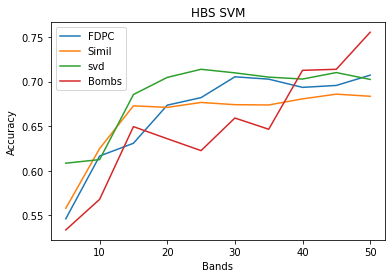

In [14]:
x = np.array([5,10,15,20,25,30,35,40,45,50])

a = np.zeros(iterations)
#b = np.zeros(iterations)
c = np.zeros(iterations)
d = np.zeros(iterations)
#e = np.zeros(iterations)
f = np.zeros(iterations)

for i in range(iterations):
    
    b_count = (i+1)*factor
    
    a[i] = HBS_accuracy["FDPC_acc_" + str(b_count)]
    #b[i] = HBS_accuracy["NC_IR_acc_" + str(b_count)]
    c[i] = HBS_accuracy["simil_acc_" + str(b_count)]
    d[i] = HBS_accuracy["svd_acc_" + str(b_count)]
    #e[i] = HBS_accuracy["EGCSR_acc_" + str(b_count)]
    f[i] = HBS_accuracy["bombs_acc_" + str(b_count)]
    
    
plt.plot(x, a, label='FDPC')  
#plt.plot(x, b, label='NC IR')  
plt.plot(x, c, label='Simil')
plt.plot(x, d, label='svd') 
#plt.plot(x, e, label='EGCSR') 
plt.plot(x, f, label='Bombs')

plt.xlabel('Bands')
plt.ylabel('Accuracy')
plt.title("HBS SVM")
plt.legend()

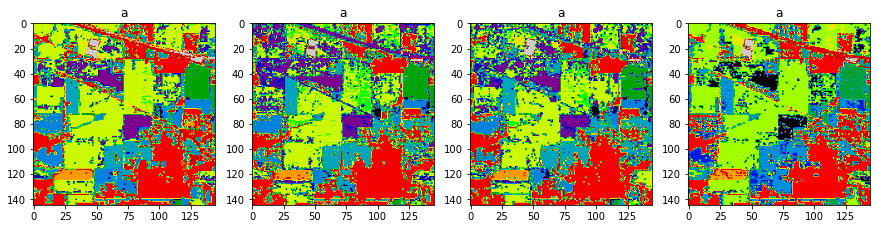

In [26]:
#Plotting classification map for all the algorithms with 10 bands
cont = 0
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
for a in HBS_class_maps:    
     
    if a[-2] == "1" and a[-1] == "0":

        im = axes[cont].imshow(HBS_class_maps[a], cmap='nipy_spectral')
        tx = axes[cont].set_title("a")
        axes[cont].grid(False)
        cont +=1